# Excersise 3 DataSci Wine dataset
## Part 1: 

Exploratory data analysis to chose model features for binary logistic regression can be seen below.  
Since there are 12 columns in the dataset, the total number of models that can be constructed, starting with 1 feature upto 12 features, is 8190. This is a very large number and emphasises the need for more targeted feature selection to reduce the number of models made. 

Here we will chose 6 variables as the features of the BLR model.

In [2]:
# Importing required modules 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

In [3]:
# Importing data and defining binary type variable 
wineData = pd.read_excel("wine-dataset.xlsx")
wineData['Type binary'] = (wineData['Type'] == 'Red').astype(int)

In [4]:
#wineData.describe()

/tmp/ipykernel_251182/2546496266.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = wineData.corr()


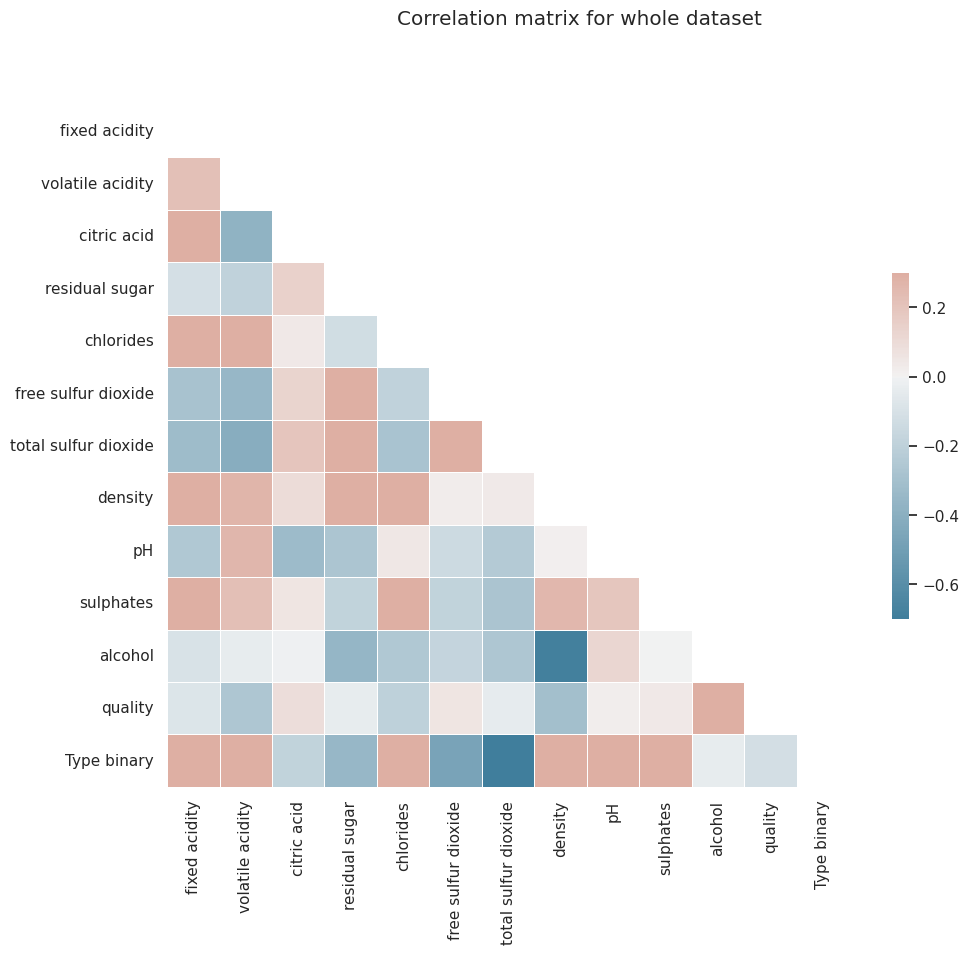

In [5]:
# Compute the correlation matrix
corr = wineData.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.suptitle("Correlation matrix for whole dataset")
plt.show()

A correlation matrix was produced for the entire dataset  

None of the variables are extremely correlated, with the maximum correlation being around -0.6, however it is still good to avoid highly correlated features such as density and alcohol in the same model to reduce colinearity.

In [6]:
# Recursive feature selection 
# Select target and features 
y = wineData["Type"]
X = wineData.drop(["Type","Good/bad","Type binary"], axis = 1)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Create instance of logistic regression object
logreg_model = LogisticRegression(max_iter = 2000)

# Create instance of RFE using logistic regression estimator and fit the data
rfe = RFE(logreg_model)
rfe = rfe.fit(X,y)
#print(rfe.support_)

print("RFE analysis of features:\n")
for i in range(X.shape[1]):
    print('Column: %s, Selected %s, Rank: %d' % (X.columns[i],rfe.support_[i], rfe.ranking_[i]))

print("\nPairplots for variables with Rank: 1 have been plotted below")

RFE analysis of features:

Column: fixed acidity, Selected True, Rank: 1
Column: volatile acidity, Selected True, Rank: 1
Column: citric acid, Selected True, Rank: 1
Column: residual sugar, Selected False, Rank: 3
Column: chlorides, Selected True, Rank: 1
Column: free sulfur dioxide, Selected False, Rank: 6
Column: total sulfur dioxide, Selected False, Rank: 5
Column: density, Selected False, Rank: 2
Column: pH, Selected True, Rank: 1
Column: sulphates, Selected True, Rank: 1
Column: alcohol, Selected False, Rank: 4
Column: quality, Selected False, Rank: 7

Pairplots for variables with Rank: 1 have been plotted below


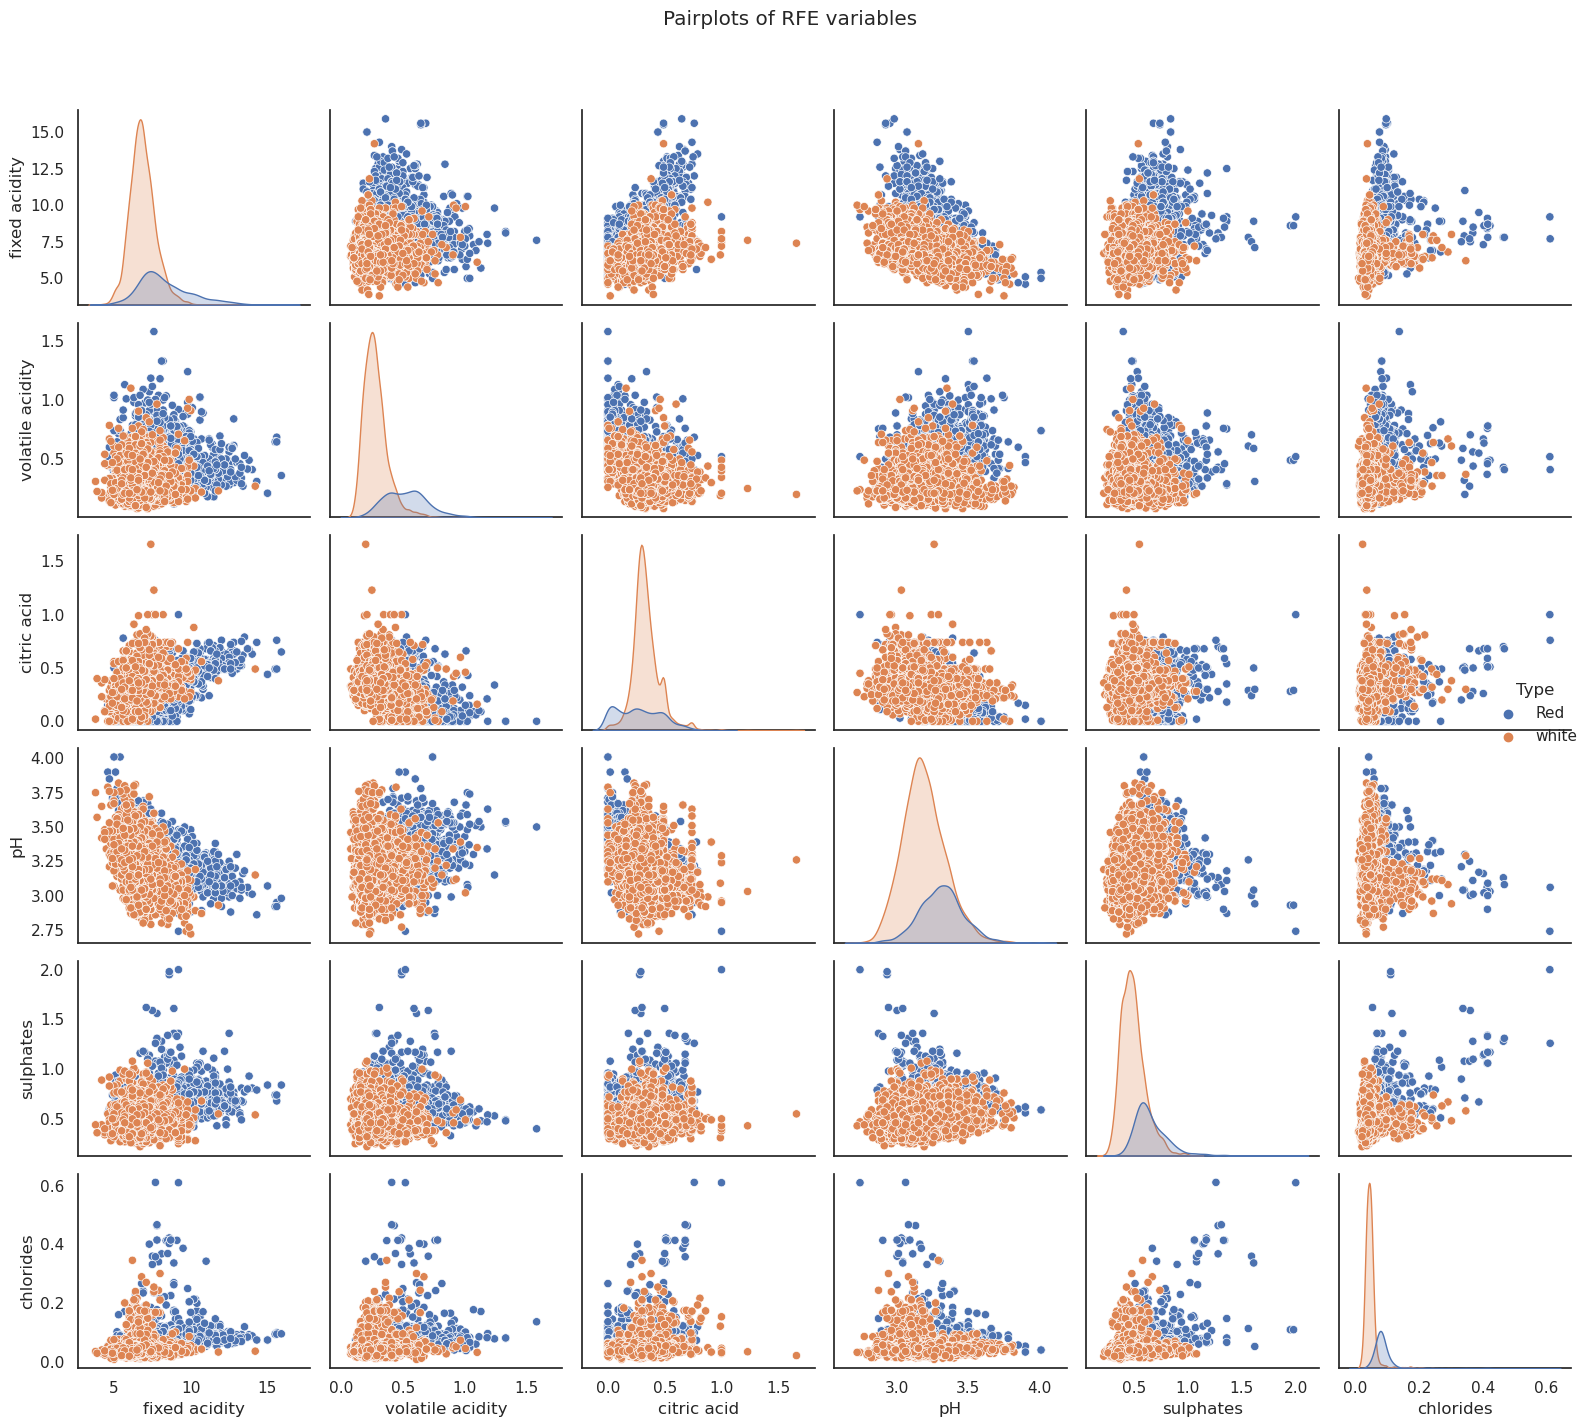

In [7]:
rfe_vars = ['fixed acidity', 'volatile acidity', 'citric acid', 'pH', 'sulphates', 'chlorides']
sns.pairplot(data=wineData, vars = rfe_vars, hue = "Type")
plt.suptitle("Pairplots of RFE variables")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Most of the pairplots look good, with red wine (blue) generally peaking after white wine (orange) suggesting that they will be good predictors for BLR.  
Citric acid stands out, with the distribution of red wine being very flat, peaking a little before the white wine, this is not ideal for a predictor and suggests that another variable should be considered.   

To further explore the relationships between the variables and the target, logistic regression plots were created, see below


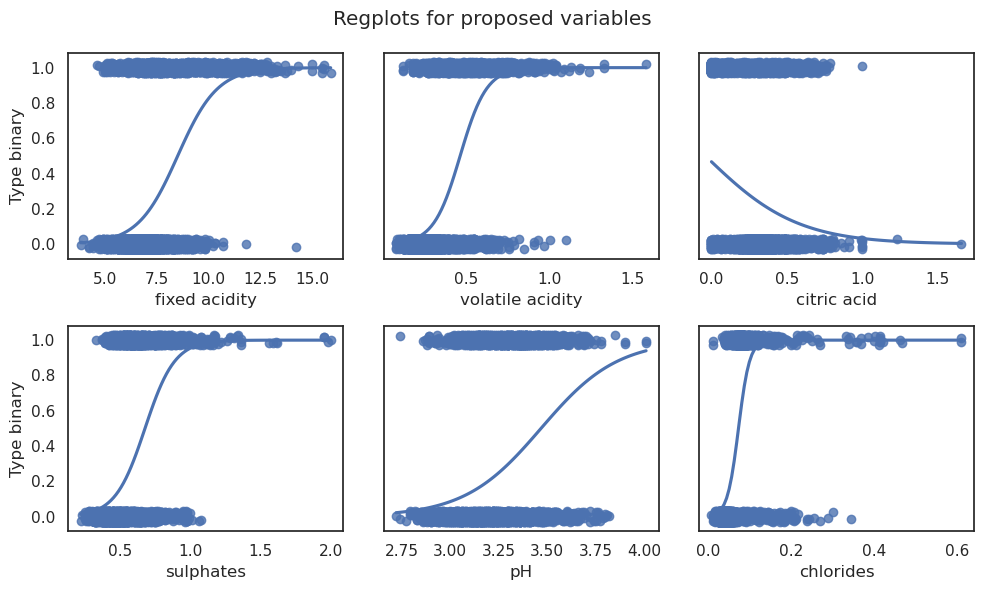

In [8]:
rows = [0, 0, 0, 1, 1, 1]
columns = [0, 1, 2, 1, 0, 2]

fig, axs = plt.subplots(2, 3, sharey=True, figsize = (10,6))

for i, var in enumerate(rfe_vars):
    sns.regplot(x=var, y="Type binary", y_jitter=0.03, data=wineData, logistic=True, ci=None, ax=axs[rows[i]][columns[i]])
    if columns[i] != 0:
        axs[rows[i]][columns[i]].set_ylabel(" ")

plt.suptitle("Regplots for proposed variables")
plt.tight_layout()
plt.show()


The regression plots show curves with a sigmoidal shape which is promising, however citric acid stands out again.  

The plots for the features with RFE ranks 2 and 3, density and residual sugar were produced with the hope of replacing citric acid.  

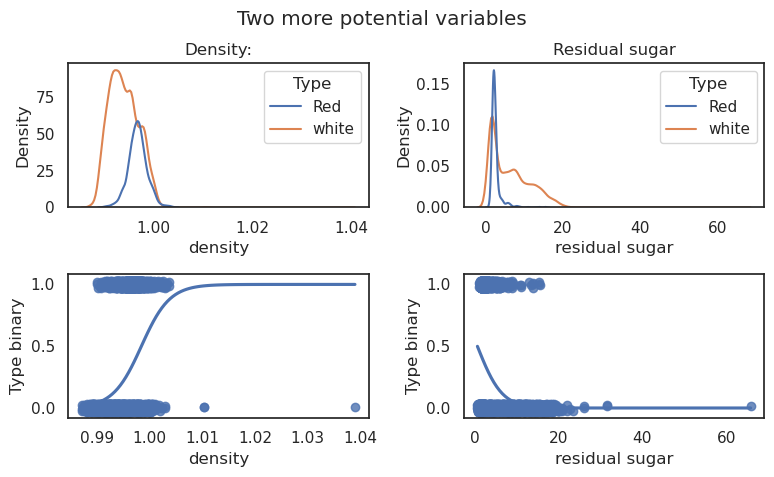

In [9]:
fig,axs = plt.subplots(2,2, figsize = (8,5))
# Create a violin plot of fixed acidity by wine type
sns.kdeplot(data=wineData, x="density", hue="Type", ax = axs[0][0])
axs[0][0].set_title('Density:')
sns.kdeplot(data=wineData, x="residual sugar", hue="Type", ax = axs[0][1])
axs[0][1].set_title('Residual sugar')

sns.regplot(x="density", y="Type binary", y_jitter=0.03, data=wineData, logistic=True, ci=None, ax = axs[1][0])
sns.regplot(x="residual sugar", y="Type binary", y_jitter=0.03, data=wineData, logistic=True, ci=None, ax = axs[1][1])
# sns.countplot(x=wineData["Type"])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Two more potential variables")
plt.show()

From the distribution and regression plots above, it seems that density is the better candidate to replace citric acid in the model. The sigmoidal curve is much more promenant and the peaks of red and white, while overlapping, are pronounced, with red wine having higher densties than white.

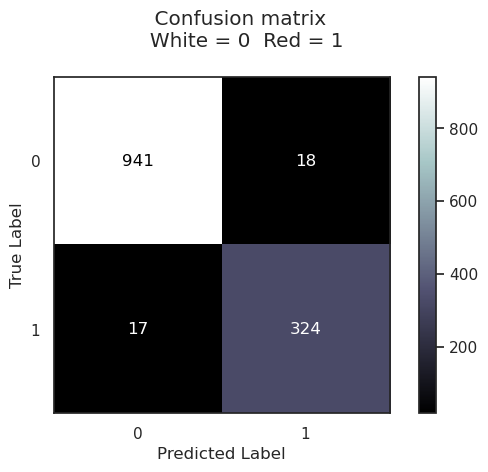

Variables:  ['chlorides', 'residual sugar', 'fixed acidity', 'volatile acidity', 'pH', 'sulphates']

Total test data: 1300, red: 341, white: 959

Accuracy: 0.973
Precision: 0.982
Recall: 0.981
F1-Score: 0.982

k-fold cross-validation performed using 5 folds: 
Mean score: 0.965
Standard deviation: 0.008


In [10]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

model_vars = ["chlorides", "residual sugar", "fixed acidity", "volatile acidity", "pH", "sulphates"]

# Select the independent variables
X = wineData[model_vars]

# Select the target variable
y = wineData['Type binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LogisticRegression object 
logreg = LogisticRegression(random_state=0, max_iter=7000)

# Fit logistic regression to the training data
clf = logreg.fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=5)

# Generate predicted classes for the test data
y_pred = clf.predict(X_test)

# Plot confusion matrix 
color = 'white'
fig,axs = plt.subplots(1,1)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "bone",ax = axs,display_labels=clf.classes_)
axs.set_xlabel('Predicted Label')
axs.set_ylabel('True Label')
fig.suptitle("            Confusion matrix \n             White = 0  Red = 1")
plt.tight_layout()
plt.show()


print("Variables: ", model_vars)

print(f"\nTotal test data: %d, red: %d, white: %d"%(len(y_test), sum(y_test), len(y_test)-sum(y_test)))

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: %0.3f" %(accuracy))

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, pos_label=0)
print(f"Precision: %0.3f" %precision)

recall = recall_score(y_test, y_pred, pos_label=0)
print(f"Recall: %0.3f"% recall)

f1 = f1_score(y_test, y_pred, pos_label=0)
print(f"F1-Score: %0.3f"% f1)

print("\nk-fold cross-validation performed using 5 folds: ")
print(f"Mean score: %0.3f" %scores.mean())
print(f"Standard deviation: %0.3f" %scores.std())

#X


Precision is the proportion of true positives (predicted positives that are actually positive) out of all predicted positives.   
It is calculated as precision = TP / (TP + FP).  

Recall (Sensitivity) is the proportion of true positives out of all actual positives.   
It is calculated as recall = TP / (TP + FN).

Specificity is the proportion of true negatives (predicted negatives that are actually negative) out of all actual negatives.  
It is calculated as specificity = TN / (TN + FP).

F1-score is a weighted average of precision and recall, which takes into account both false positives and false negatives.   
It is calculated as F1 = 2 * (precision * recall) / (precision + recall).

All in all our model seems to be accurate, correctly predicting 97.3% of the training data using a binary regression model using 6 variables from the original dataset. The Precision, Recall and F1 values are all above 98% suggesting that a positive prediction will be correct 98.2% of the time and the model correctly predicted 98.1% of positives in the test data

A cross validation has been performed using k-fold cross validation, k=5, the results indicate that the model is accurate and the small standard deviation suggests there is little variation in the accuracy of predictions.

The correlation matrix shows that 25.2% of the test data has been assigned as red wine, and 74.7% has been assigned as white which is in agreement with the distribution in the training dataset of 26.2 and 73.8% respectively. This shows that while there was a small skew in the balance of our original dataset the predictive power seems largely unaffected. There are instances where the model is incorrectly identifying some negative instances as positives and vice versa but these incorrect predictions account for only 2.7% of predictions.

While the regplot for citric acid doesnt look to be sigmoidal in nature and therefore doesnt seem to be a good predictor, the model accuracy parameters all reflect an increase in accuracy when citric acid is used over density as a predictor. Conversely, the model accuracy increases from 96.2% to 97.3% with the inclusion of residual sugar over citric acid therefore residual sugar has been included in the model over citric acid.

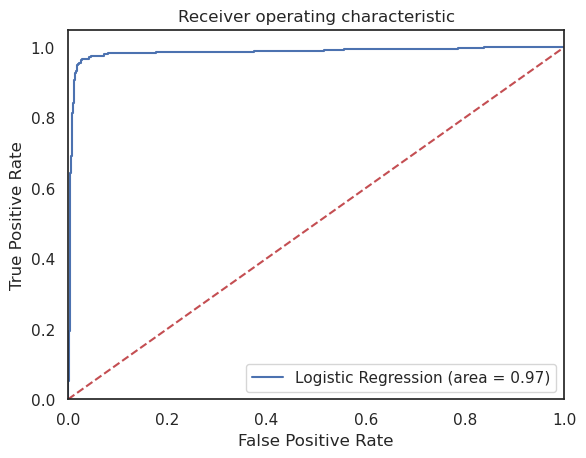

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

this ROC curve seems almost perfect, covering 97% of the area and having a steep initial increase in true positive rate. 

Some limitations of the binary logistic regression models include the limitation to predicting binary outcomes making it unsuitable for some applications. BLR assumes that there is no multicollinearity in the dataset, something we have worked around in the exploratory analysis. Lastly Logistic regression assumes a linear relationship between the independent variables and the logit of the dependent variables when this is not always the case - leading to biased results.

# Part 2a: Bayesian distribution for wine quality

Let the variable 𝜃 denote the probability that the wine quality is rated as “good”. For the purposes of
this exercise, “good” is defined as having a quality score which is 6 or higher. A bayesian approach will be used to estimate the average theta value for the whole dataset, further the affect of citric acid on the value of theta will be investigated

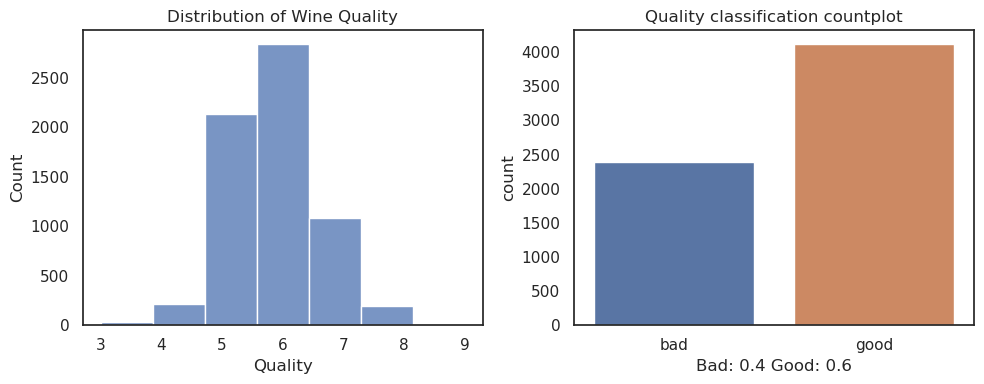

In [12]:
fig, axs = plt.subplots(1,2, figsize = (10,4))

# Create a histogram of the wine quality
sns.histplot(wineData['quality'], bins=7, kde=False, ax = axs[0])
axs[0].set_title('Distribution of Wine Quality')
axs[0].set_xlabel('Quality')
axs[0].set_ylabel('Count')

sns.countplot(x=wineData["Good/bad"])
axs[1].set_title("Quality classification countplot")

pc_good = sum(wineData["quality"] >= 6)/len(wineData)
pc_bad = 1-pc_good
axs[1].set_xlabel((f"Bad: %0.1f Good: %0.1f"%(pc_bad,pc_good)))

plt.tight_layout()
plt.show()



Wine quality is fairly evenly distributed around around the value of 6, choosing 6 as the threshold for good/bad results in 60% of the wines being classed as good wines. In practice this may be a little high but it depends on your perspective when classifying wines by quality.   

The resulting classification is a binary variable, either the wine is good or it is not. Therefore the likelihood for the bayesian inference should be a binomial, either it does or doesnt happen. this will be paired with the conjugate beta prior. The initial values of alpha and beta were chosen to be 4 and 3 respectively, as we know there is a skew towards good rated wines in the dataset. A beta posterior will be produced, making it easy to update the distribution as we go

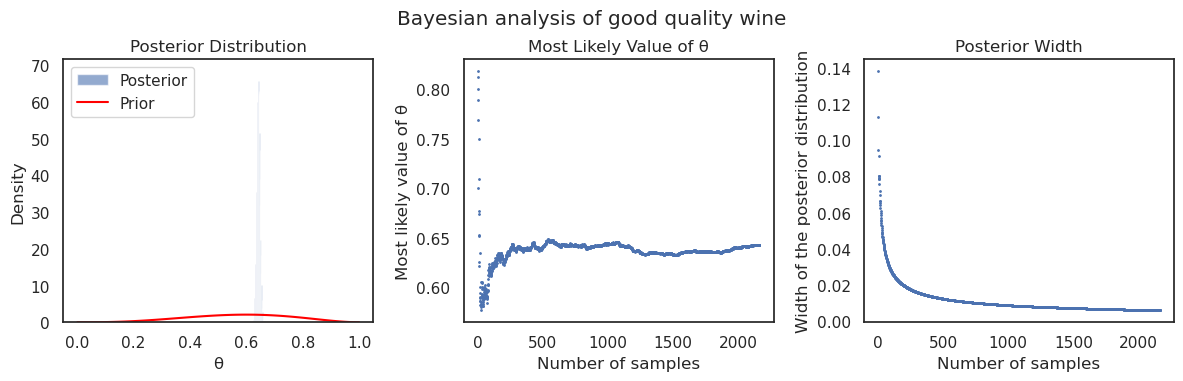

Average theta: 0.642 	 Posterior width: 0.006


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, binom
import math
    
# Load the wine dataset
wine = wineData

# Define the prior distribution
alpha = 4
beta_ = 3
prior = beta(alpha, beta_)

# Set the number of iterations
n_samples = 3
n_iterations = np.floor(len(wineData)/n_samples).astype(int)

# Initialize variables to track the posterior distribution
posterior = prior
most_likely_theta = []
posterior_width = []

# Iterate over the dataset
for i in range(n_iterations):
    
    # Draw a random sample from the dataset
    sample = wineData.sample(n=n_samples, replace = False)
    
    # Count the number of "good" wines in the sample
    x = sum(sample["quality"] >= 6)
    
    # Compute the posterior distribution
    post_alpha, post_beta = alpha+x, beta_+n_samples-x
    posterior = beta(post_alpha, post_beta)
    alpha, beta_ = post_alpha,post_beta
    
    # Track the most likely value of theta and the posterior width
    most_likely_theta.append(posterior.mean())
    posterior_width.append(posterior.std())
    
fig, axs = plt.subplots(1,3, figsize = (12,4))
# Plot the posterior distribution
axs[0].hist(posterior.rvs(10000), bins=50, alpha = 0.6, density=True, label='Posterior')
axs[0].plot(np.linspace(0, 1, 100), prior.pdf(np.linspace(0, 1, 100)), color='red', label='Prior')
axs[0].set_xlabel('θ')
axs[0].set_ylabel('Density')
axs[0].set_title('Posterior Distribution')
axs[0].legend()

xs = np.arange(1,n_iterations+1,1)

# Plot how the most likely value of theta and the width of the posterior distribution change with the number of samples
axs[1].scatter(x= xs,y = most_likely_theta, s=1)
axs[1].set_xlabel('Number of samples')
axs[1].set_ylabel('Most likely value of θ')
axs[1].set_title('Most Likely Value of θ')

axs[2].scatter(x = xs, y=posterior_width, s=1)
axs[2].set_xlabel('Number of samples')
axs[2].set_ylabel('Width of the posterior distribution')
axs[2].set_title('Posterior Width')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Bayesian analysis of good quality wine")
plt.show()

print(f"Average theta: %0.3f \t Posterior width: %0.3f"%(posterior.mean(),posterior.std()))

Above, the final posterior distribution and tracking plots following most likely theta value and posterior width can be seen.  
The average value  of theta has converged to ~63% and has a width of 0.006. Large sways can be seen in the initial values of theta, however as more data was added this was lost and the value converges. This is reflected in the posterior width decreasing as the number of samples added increases.

## Part 2b:

To investigate the value of theta as a function of citric acid, the citric acid column was split into approximately equally populated bins, see figure below . Subsequently, the posterior distribution of theta was calculated based on data in each bin and plotted, see figure below. The data in each bin has been randomly sampled without replacement to iteratively feed data into the model.    

Plots can be seen below showing the population of each bin, verifying that they are approximately equally populated, and visualising the range of values of citric acid that they each cover.

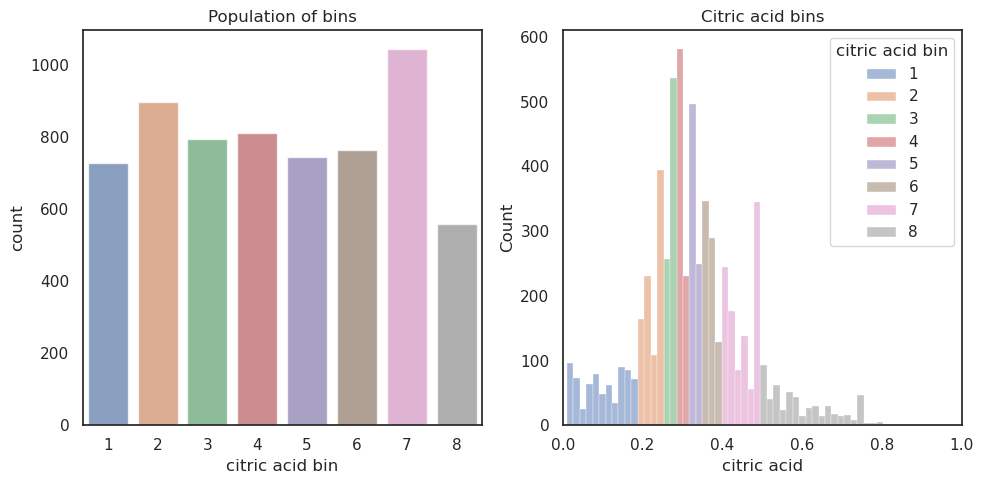

Bin 1: min=0.01, max=0.18
Bin 2: min=0.19, max=0.25
Bin 3: min=0.26, max=0.28
Bin 4: min=0.29, max=0.31
Bin 5: min=0.32, max=0.34
Bin 6: min=0.35, max=0.39
Bin 7: min=0.40, max=0.49
Bin 8: min=0.50, max=1.66


In [20]:
from matplotlib.pyplot import cm

# Split the citric acid column into bins with approximately equal number of elements
n_bins = 8
color=iter(cm.tab10(np.linspace(0,1,n_bins+1)))
bins = np.linspace(0, 1, n_bins+1)
quantiles = wineData['citric acid'].quantile(bins)

# Assign each data point to a bin
bin_labels = np.arange(1, n_bins+1)
wineData['citric acid bin'] = pd.cut(wineData['citric acid'], quantiles, labels=bin_labels)


fig, axs = plt.subplots(1,2,figsize = (10,5))
sns.countplot(x = wineData['citric acid bin'],ax = axs[0], alpha = 0.7)
sns.histplot(data=wineData, x = "citric acid", hue = "citric acid bin", ax = axs[1])
axs[1].set_xlim((0,1))

axs[0].set_title("Population of bins")
axs[1].set_title("Citric acid bins")

plt.tight_layout()
plt.show()

grouped = wineData.groupby('citric acid bin')['citric acid']
for label, group in grouped:
    print(f"Bin {label}: min={group.min():.2f}, max={group.max():.2f}")

The value of theta and the width of the posterior distribution have been tracked thoughout the calculation and have been output below.   

The theta tracking values have been plotted below along with the final posterior distributions of theta. For each posterior distribution the mean value of theta and the posterior width has been displayed.

Bin: 1 	 Average theta: 0.41 	 Posterior width: 0.02
Bin: 2 	 Average theta: 0.52 	 Posterior width: 0.02
Bin: 3 	 Average theta: 0.73 	 Posterior width: 0.02
Bin: 4 	 Average theta: 0.77 	 Posterior width: 0.01
Bin: 5 	 Average theta: 0.73 	 Posterior width: 0.02
Bin: 6 	 Average theta: 0.70 	 Posterior width: 0.02
Bin: 7 	 Average theta: 0.65 	 Posterior width: 0.01
Bin: 8 	 Average theta: 0.54 	 Posterior width: 0.02


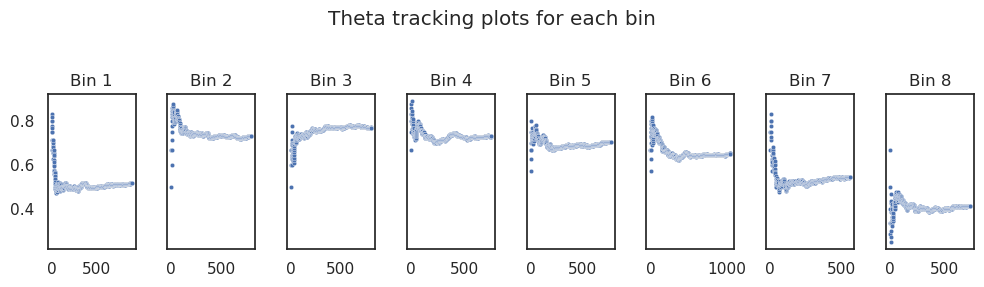

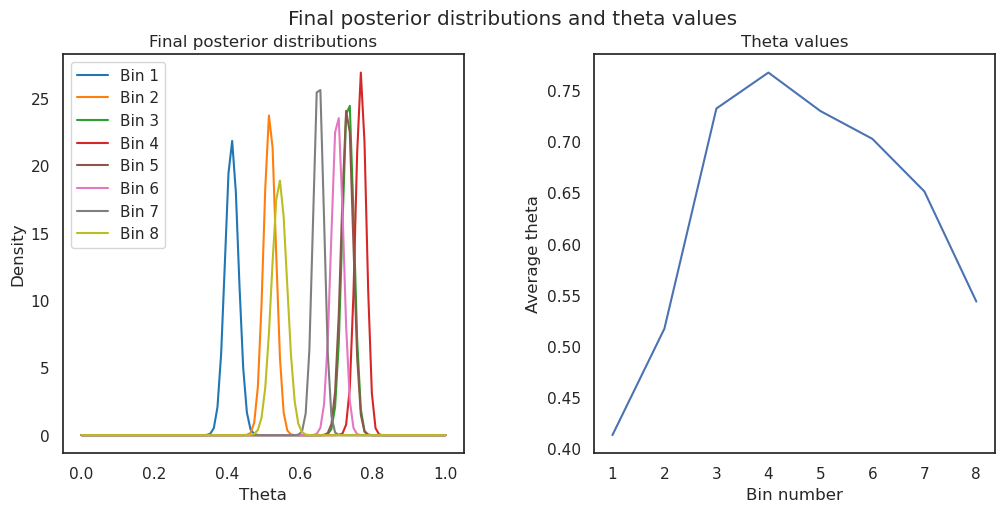

In [21]:
from matplotlib.pyplot import cm
from scipy.stats import beta

# Initialise figures for plotting
fig, axs = plt.subplots(1,n_bins, figsize = (10,3), sharey = True)
fig2, axs2 = plt.subplots(1,2, figsize = (10,5))

final_theta = []

# Calculate posterior distribution for each bin
for i in range(n_bins):
    # Extract wines in bin i
    bin_data = wineData[wineData['citric acid bin'] == i+1]
    
    # Initialise prior and storage arrays for each bin 
    alpha = 1
    beta_ = 1
    posterior_width = []
    most_likely_theta = []
    prior = beta(alpha, beta_)
    posterior = prior
    
    # Calculate the number of data in bins to iterate over
    n_samples = 1
    n_iterations = len(bin_data)
    
    # Iterate over the dataset
    for j in range(n_iterations):

        # Draw a random sample from the dataset
        sample = bin_data.sample(n=n_samples, replace=False)

        # Count the number of "good" wines in the sample
        x = sum(sample["quality"] >= 6)

        # Compute the posterior distribution
        post_alpha, post_beta = alpha+x, beta_+n_samples-x
        posterior = beta(post_alpha, post_beta)
        alpha, beta_ = post_alpha, post_beta
        
        # Track the most likely value of theta and the posterior width
        most_likely_theta.append(posterior.mean())
        posterior_width.append(posterior.std())
        
    #Plot theta tracking for each bin 
    c=next(color)
    sns.scatterplot(x=np.arange(1,len(most_likely_theta)+1,1), y= most_likely_theta, ax = axs[i-1], s=10 )
    axs[i].set_title(f"Bin %s"%(i+1))
    
    # Plot posterior distribution for each bin
    sns.lineplot(x = np.linspace(0, 1, 100), y = posterior.pdf(np.linspace(0, 1, 100)), label=f'Bin {i+1}',ax = axs2[0], color = c)
    
    final_theta.append(posterior.mean())
    
    print(f"Bin: %s \t Average theta: %0.2f \t Posterior width: %0.2f" %(i+1, posterior.mean(), posterior.std()))

sns.lineplot(x = np.arange(1,n_bins+1), y = final_theta, ax = axs2[1])
fig.suptitle("Theta tracking plots for each bin")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig2.suptitle("Final posterior distributions and theta values")
fig2.tight_layout(w_pad = 5)
axs2[0].set_xlabel("Theta")
axs2[0].set_ylabel("Density")
axs2[0].set_title("Final posterior distributions")
axs2[1].set_xlabel("Bin number")
axs2[1].set_ylabel("Average theta")
axs2[1].set_title("Theta values")
plt.show()

Looking at the theta tracking plots for each bin, it can be seen that each has converged roughly, and a general pattern of an increase in final theta value before a decrease again.   

The posterior distributions for each bin can be seen in the lower left plot, These are all sharp with posterior widths of <=0.02 which is within a standard deviation of the average theta value for each distribution.   

The lower right hand plot shows the relationship of citric acid bins with the average value of theta. It can be seen to peak at bins 4 & 5 before returning. If we remember that theta is the probability of the wine being good, it seems that there is a sweet spot in citric acid content of wine that results in it attaining a higher quality rating, and therefore increases the chance it will be classified as "good".   

This sweet spot comes between 0.29 and 0.34 g.dm-3 according to bayesian inference to investigate the value of theta as a function of citric acid. This is important as it can help wine makers to tune their wine to the market in the hopes of producing more highly rated wines   

A similar analysis can be performed on other features of the dataset to investigate which of the features has the biggest impact on the average value of theta. The analysis on citric acid concentrations could be altered to have more bin and therefore create a more accurate curve for the relationship between citric acid and theta. Changing the value of threshold and therefore the value of theta should not change the pattern in the curve.

Considering the range of average theta values that have been presented by calculating the posterior distributions in each bin, and the average value of theta for the whole dataset, Our initial threshold of 6 is sensible. Saying this, the results may be more significant if the threshold was higher as this would lead to more stringient criteria for assigning a wine as "good". The value of the quality threshold can be changed to fit the number of wines that you want to classify as good, the higher the value the less wines will be classified as good.   